# Imports

In [1]:
import imageio as imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import math
from ipywidgets import interact, widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
from pydicom import dcmread

# Read image and convert to gray scale
Enter image path

In [2]:
image_path = 'tomograf-zdjecia/Shepp_logan.jpg'

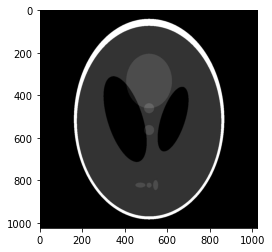

In [3]:
input_image_color = imageio.imread(image_path)
input_image = color.rgb2gray(input_image_color)
plt.imshow(input_image, cmap='gray')
input_image_height, input_image_width = input_image.shape

# Radon transform
Enter data below

In [4]:
emitters_step = 1
detectors_amount = 60
detectors_spread = 270

Generate sinogram height and width

In [5]:
emitters_start_degree = 0
emitters_end_degree = 360 - emitters_step
sinogram_height = math.ceil((emitters_end_degree - emitters_start_degree)/emitters_step)+1
sinogram_width = detectors_amount

Create list of angles

In [6]:
endpoint_angle = (sinogram_height-1) * emitters_step
angles = np.linspace(start=emitters_start_degree, stop=endpoint_angle, num=sinogram_height, endpoint=True)

Convert angles to radians

In [7]:
radian_angles = np.radians(angles)
radian_emitters_step = np.radians(emitters_step)
radian_spread = np.radians(detectors_spread)
radian_180 = np.radians(180)


Calculate distance to center of image in x and y axises

In [8]:
center_x = (input_image_width-1)/2
center_y = (input_image_height-1)/2

Calculate radius

In [9]:
radius = min(center_x, center_y)

Bresenham's line algorithm

In [10]:
def bresenham_line(x1, y1, x2, y2):
    coordinates = []
    # zmienne pomocnicze
    x = x1
    y = y1
    # ustalenie kierunku rysowania
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
    # ustalenie kierunku rysowania
    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
    # pierwszy piksel
    coordinates.append([x, y])
    # oś wiodąca OX
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        # pętla po kolejnych x
        while x != x2:
            # test współczynnika
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
            coordinates.append([x, y])
    # oś wiodąca OY
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        # pętla po kolejnych y
        while y != y2:
            # test współczynnika
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
            coordinates.append([x, y])
    
    return coordinates

Type whether filter should be active

In [11]:
active_filter = True

Create sinogram function

In [12]:
def calculate_sinogram(sinogram_height=sinogram_height, sinogram_width=sinogram_width, input_image=input_image,
                       radian_angles=radian_angles, radian_spread=radian_spread, detectors_amount=detectors_amount):
    sinogram = np.zeros((sinogram_height, sinogram_width))
    for sinogram_y, radian_angle in enumerate(radian_angles[:sinogram_height]):
        radian_emitter_angles = np.linspace(start=radian_angle-radian_spread/2, stop=radian_angle+radian_spread/2,
                                            num=detectors_amount, endpoint=True)
        x_emitter = round(center_x - np.cos(radian_angle) * radius)
        y_emitter = round(center_y - np.sin(radian_angle) * radius)
        for sinogram_x, radian_emitter_angle in enumerate(radian_emitter_angles):
            x_detector = round(center_x - np.cos(radian_emitter_angle+radian_180) * radius)
            y_detector = round(center_y - np.sin(radian_emitter_angle+radian_180) * radius)
            index_coordinates = bresenham_line(x_emitter, y_emitter, x_detector, y_detector)
            sum_values = 0
            for x_index, y_index in index_coordinates:
                sum_values += input_image[y_index][x_index]
            value = sum_values/len(index_coordinates)
            sinogram[sinogram_y][sinogram_x] = value
    
    return sinogram

Create sinogram function with active filter

In [13]:
def calculate_sinogram_with_filter(sinogram_height=sinogram_height, sinogram_width=sinogram_width, input_image=input_image,
                       radian_angles=radian_angles, radian_spread=radian_spread, detectors_amount=detectors_amount):
    
    sinogram = calculate_sinogram(sinogram_height, sinogram_width, input_image, radian_angles, radian_spread, detectors_amount)
    sinogram_with_filter = np.zeros((sinogram_height, sinogram_width))
    for i in range(sinogram_height):
        for j in range(sinogram_width):
            new_x = 0
            mask_half = 15
            start_index = j - mask_half
            if start_index<0:
                start_index=0
            end_index = j + mask_half
            if end_index>=sinogram_width:
                end_index=sinogram_width-1
            for k, x in enumerate(sinogram[i,start_index:end_index]):
                index = start_index+k-j
                if index == 0:
                    weight = 1
                elif index%2 == 0:
                    weight = 0
                else:
                    weight = -4/(math.pi**2 * index**2)
                new_x += x*weight
            sinogram_with_filter[i][j] = new_x
    return sinogram_with_filter

Visualize sinogram

In [14]:
@widgets.interact(Step=(0,sinogram_height))
def visualize_sinogram(Step=sinogram_height):
    if active_filter:
        sinogram_to_visualize = calculate_sinogram_with_filter(Step)
    else:
        sinogram_to_visualize = calculate_sinogram(Step)
    plt.imshow(sinogram_to_visualize, cmap="gray")

interactive(children=(IntSlider(value=360, description='Step', max=360), Output()), _dom_classes=('widget-inte…

Create sinogram

In [15]:
if active_filter:
    sinogram = calculate_sinogram_with_filter()
else:
    sinogram = calculate_sinogram()

# Reverse Radon transform

Create output image function

In [16]:
def calculate_output_image(sinogram_height=sinogram_height, radian_angles=radian_angles, radian_spread=radian_spread,
                           detectors_amount=detectors_amount, sinogram=sinogram):
    output_image = np.zeros((input_image_height, input_image_width))
    amount_of_values = np.zeros((input_image_height, input_image_width))
    for sinogram_y, radian_angle in enumerate(radian_angles[:sinogram_height]):
        radian_emitter_angles = np.linspace(start=radian_angle-radian_spread/2, stop=radian_angle+radian_spread/2,
                                            num=detectors_amount, endpoint=True)
        x_emitter = round(center_x - np.cos(radian_angle) * radius)
        y_emitter = round(center_y - np.sin(radian_angle) * radius)
        for sinogram_x, radian_emitter_angle in enumerate(radian_emitter_angles):
            x_detector = round(center_x - np.cos(radian_emitter_angle+radian_180) * radius)
            y_detector = round(center_y - np.sin(radian_emitter_angle+radian_180) * radius)
            index_coordinates = bresenham_line(x_emitter, y_emitter, x_detector, y_detector)
            for x_index, y_index in index_coordinates:
                output_image[y_index][x_index] += sinogram[sinogram_y][sinogram_x]
                amount_of_values[y_index][x_index] += 1

    for i in range(input_image_height):
        for j in range(input_image_width):
            if amount_of_values[i][j]>1:
                output_image[i][j] = output_image[i][j]/amount_of_values[i][j]
    
    return output_image

Visualize output image

In [17]:
@widgets.interact(Step=(0,sinogram_height))
def visualize_output_image(Step=sinogram_height):
    output_image_to_visualize = calculate_output_image(Step)
    plt.imshow(output_image_to_visualize, cmap="gray")

interactive(children=(IntSlider(value=360, description='Step', max=360), Output()), _dom_classes=('widget-inte…

Create output image

In [18]:
output_image = calculate_output_image()

# Save image as dicom

Create patient_data

In [19]:
patient_data = dict()

Enter data about patient and image

In [20]:
patient_data["PatientName"] = "Nowak"
patient_data["PatientID"] = "2423454"
patient_data["ImageComments"] = "It is fine"
file_name = "test_dicom.dcm"

Save as dicom function

In [21]:
def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)

Save as dicom

In [22]:
save_as_dicom(file_name, output_image, patient_data)

Read dicom

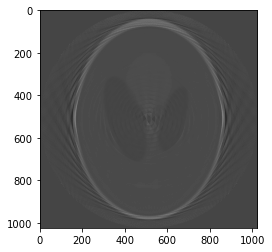

PatientName: Nowak
PatientID: 2423454
ImageComments: It is fine


In [23]:
dicom_file = pydicom.read_file(file_name)
pixel_data = dicom_file.pixel_array
plt.imshow(pixel_data, cmap='gray')
plt.show()
print("PatientName:", dicom_file.PatientName)
print("PatientID:", dicom_file.PatientID)
print("ImageComments:", dicom_file.ImageComments)

# Statistical analysis - root mean square error

Normalize output_image function

In [24]:
def normalize_output_image(output_image):
    min_value_output_image = np.min(output_image)
    max_value_output_image = np.max(output_image)
    normalized_output_image = (output_image - min_value_output_image) / (max_value_output_image - min_value_output_image)
    return normalized_output_image

Calculate root mean square error function

In [25]:
def calculate_rmse(input_img, output_img):
    normalized_output_img = normalize_output_image(output_img)
    mse = 0
    for i in range(input_img.shape[0]):
        for j in range(input_img.shape[1]):
            mse += (input_img[i, j] - normalized_output_img[i, j]) ** 2
    mse = mse / (input_image_height * input_image_width)
    rmse = mse ** 0.5
    return rmse

Calculate RMSE

In [26]:
rmse = calculate_rmse(input_image, output_image)
rmse

0.2517756726904529

Process input image with input parameters and return rmse

In [27]:
def process_input_image(file_name, emitters_step=2, detectors_amount=180, detectors_spread=180):
    emitters_start_degree = 0
    emitters_end_degree = 360 - emitters_step
    sinogram_height = math.ceil((emitters_end_degree - emitters_start_degree)/emitters_step)+1
    sinogram_width = detectors_amount

    endpoint_angle = (sinogram_height-1) * emitters_step
    angles = np.linspace(start=emitters_start_degree, stop=endpoint_angle, num=sinogram_height, endpoint=True)
    
    radian_angles = np.radians(angles)
    radian_emitters_step = np.radians(emitters_step)
    radian_spread = np.radians(detectors_spread)

    sinogram = calculate_sinogram(sinogram_height, sinogram_width, input_image, radian_angles, radian_spread, detectors_amount)

    output_image = calculate_output_image(sinogram_height, radian_angles, radian_spread, detectors_amount, sinogram)
    
    save_as_dicom(file_name, output_image, patient_data)
    
    rmse = calculate_rmse(input_image, output_image)
    return rmse

Calculate rmse with different detectors amount

In [28]:
rmse_detectors_amount_y = []
rmse_detectors_amount_x = range(90, 721, 90)
for x in rmse_detectors_amount_x:
    rmse = process_input_image("detectors_amount_" + str(x) +".dcm", detectors_amount=x)
    rmse_detectors_amount_y.append(rmse)
rmse_detectors_amount_y

[0.32976556207412916,
 0.39546829969269076,
 0.35452905486328656,
 0.39402269126519857,
 0.432354849581432,
 0.41078966279693396,
 0.47111889051490513,
 0.46107494342771266]

Plot rmse with different detectors amount

Text(0, 0.5, 'Wartość RMSE')

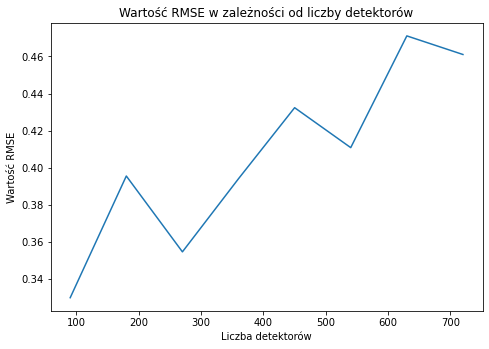

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(rmse_detectors_amount_x, rmse_detectors_amount_y)
ax.set_title("Wartość RMSE w zależności od liczby detektorów")
ax.set_xlabel("Liczba detektorów")
ax.set_ylabel("Wartość RMSE")

Calculate rmse with different emitters step amount

In [30]:
rmse_emitters_step_y = []
rmse_emitters_step_x = range(90, 721, 90)
for x in rmse_emitters_step_x:
    rmse = process_input_image("emitters_step_" + str(x) +".dcm", emitters_step=360.0/x)
    rmse_emitters_step_y.append(rmse)
rmse_emitters_step_y

[0.3703023769566712,
 0.39546829969269076,
 0.4698126334674543,
 0.4022218576753074,
 0.4259849827445627,
 0.5158426790678472,
 0.4287402180684741,
 0.5476203681544509]

Plot rmse with different emitters step

Text(0, 0.5, 'Wartość RMSE')

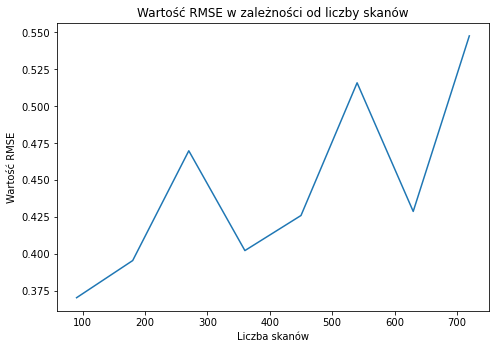

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(rmse_emitters_step_x, rmse_emitters_step_y)
ax.set_title("Wartość RMSE w zależności od liczby skanów")
ax.set_xlabel("Liczba skanów")
ax.set_ylabel("Wartość RMSE")

Calculate rmse with different detectors spread

In [32]:
rmse_detectors_spread_y = []
rmse_detectors_spread_x = range(45, 271, 45)
for x in rmse_detectors_spread_x:
    rmse = process_input_image("detectors_spread_" + str(x) +".dcm", detectors_spread=x)
    rmse_detectors_spread_y.append(rmse)
rmse_detectors_spread_y

[0.43778086002135475,
 0.44915005191775553,
 0.5372797499682848,
 0.39546829969269076,
 0.35666988293210805,
 0.23907331802052711]

Plot rmse with different detectors spread

Text(0, 0.5, 'Wartość RMSE')

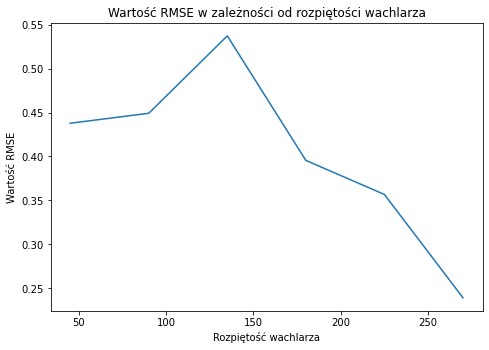

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(rmse_detectors_spread_x, rmse_detectors_spread_y)
ax.set_title("Wartość RMSE w zależności od rozpiętości wachlarza")
ax.set_xlabel("Rozpiętość wachlarza")
ax.set_ylabel("Wartość RMSE")